# Moselle paper: Distributed model

In [1]:
import pandas as pd
import datetime as datetime
import matplotlib.pyplot as plt
import numpy as np
import spotpy
import time
import os
import tqdm as tqdm
import hydroanalysis
from utils.functions import find_max_unique_rows
from utils.functions import find_iterative_immediate_downstream

In [2]:
path_estreams = r'C:\Users\nascimth\Documents\data\EStreams'

In [3]:
network_estreams = pd.read_csv(path_estreams+'\streamflow_gauges/estreams_gauging_stations.csv', encoding='utf-8')
network_estreams.set_index("basin_id", inplace = True)

# Convert 'date_column' and 'time_column' to datetime
network_estreams['start_date'] = pd.to_datetime(network_estreams['start_date'])
network_estreams['end_date'] = pd.to_datetime(network_estreams['end_date'])

# Convert to list both the nested_catchments and the duplicated_suspect columns
network_estreams['nested_catchments'] = network_estreams['nested_catchments'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))

# Remove the brackets and handle NaN values
network_estreams['duplicated_suspect'] = network_estreams['duplicated_suspect'].apply(
    lambda x: x.strip("[]").replace("'", "").split(", ") if isinstance(x, str) else x)

network_estreams

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,num_continuous_days,num_days_gaps,num_days_reliable,num_days_noflag,num_days_suspect,gauge_flag,duplicated_suspect,watershed_group,gauges_upstream,nested_catchments
basin_id,,,,,,,,,,,,,,,,,,,,,
AT000001,200014,Bangs,AT,AT_EHYD,Rhein,9.534835,47.273748,9.534835,47.273748,420,...,9497,0.0,0.0,9497.0,0.0,B,[CH000197],1,16,"[AT000001, CH000010, CH000046, CH000048, CH000..."
AT000002,200048,Schruns (Vonbunweg),AT,AT_EHYD,Litz,9.913677,47.080301,9.913677,47.080301,673,...,23103,0.0,0.0,23103.0,0.0,B,[CH000221],1,1,[AT000002]
AT000003,231662,Loruens-Aeule,AT,AT_EHYD,Ill,9.847765,47.132821,9.847765,47.132821,579,...,13513,0.0,0.0,13513.0,0.0,B,[CH000215],1,2,"[AT000002, AT000003, CH000221]"
AT000004,200592,Kloesterle (OEBB),AT,AT_EHYD,Alfenz,10.061843,47.128994,10.061843,47.128994,1014,...,8765,0.0,0.0,8765.0,0.0,B,[CH000227],1,1,[AT000004]
AT000005,200097,Buers (Bruecke L82),AT,AT_EHYD,Alvier,9.802668,47.150770,9.802668,47.150770,564,...,10957,0.0,0.0,10957.0,0.0,B,[CH000214],1,3,"[AT000005, CH000214]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UAGR0017,6682300,BASHTANOVKA,UA,UA_GRDC,KACHA,33.894739,44.691884,33.900000,44.683333,NaN,...,3652,0.0,0.0,3652.0,0.0,B,NaN,1988,1,[UAGR0017]
UAGR0018,6682500,YALTA,UA,UA_GRDC,DERE-KIOY,34.166667,44.500000,34.166667,44.500000,16,...,3652,0.0,0.0,3652.0,0.0,B,NaN,1989,1,[UAGR0018]
UAGR0019,6683010,PIONERSKOE,UA,UA_GRDC,SALHYR,34.199841,44.887685,34.200000,44.883333,307,...,3652,0.0,0.0,3652.0,0.0,B,NaN,1990,1,[UAGR0019]


In [4]:
nested_catchments = pd.DataFrame(network_estreams['nested_catchments'])

# Now we add the outlet to the list (IF it was not before):
# Ensure that the basin_id is in the nested_catchments
for basin_id in nested_catchments.index:
    if basin_id not in nested_catchments.at[basin_id, 'nested_catchments']:
        nested_catchments.at[basin_id, 'nested_catchments'].append(basin_id)

nested_catchments

,nested_catchments
basin_id,
AT000001,"[AT000001, CH000010, CH000046, CH000048, CH000..."
AT000002,[AT000002]
AT000003,"[AT000002, AT000003, CH000221]"
AT000004,[AT000004]
AT000005,"[AT000005, CH000214]"
...,...
UAGR0017,[UAGR0017]
UAGR0018,[UAGR0018]
UAGR0019,[UAGR0019]


In [5]:
#estreams_attributes = pd.read_csv('data/exploration/estreams_attributes_filtered_moselle_sm_su_tog.csv', encoding='utf-8')
estreams_attributes = pd.read_csv('../data/filtered_dataset/estreams_attributes_filtered_quality_geology_v01.csv', encoding='utf-8')

estreams_attributes.set_index("basin_id", inplace = True)

# Convert to list both the nested_catchments and the duplicated_suspect columns
estreams_attributes['nested_catchments'] = estreams_attributes['nested_catchments'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))

# Remove the brackets and handle NaN values
estreams_attributes['duplicated_suspect'] = estreams_attributes['duplicated_suspect'].apply(
    lambda x: x.strip("[]").replace("'", "").split(", ") if isinstance(x, str) else x)

estreams_attributes.sort_index(inplace = True) 
estreams_attributes

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,lulc_2006_agriculture,dam_num,res_num,lakes_num,lakes_tot_area,lakes_tot_vol,sno_cov_mean,irri_1990,irri_2005,stations_num_p_mean
basin_id,,,,,,,,,,,,,,,,,,,,,
AT000001,200014,Bangs,AT,AT_EHYD,Rhein,9.534835,47.273748,9.534835,47.273748,420,...,0.127,23.0,10.0,10.0,6.62,542.33,33.844,23.025,29.307,22.0
AT000003,231662,Loruens-Aeule,AT,AT_EHYD,Ill,9.847765,47.132821,9.847765,47.132821,579,...,0.040,4.0,4.0,3.0,1.46,12.91,36.927,0.000,0.204,18.0
AT000005,200097,Buers (Bruecke L82),AT,AT_EHYD,Alvier,9.802668,47.150770,9.802668,47.150770,564,...,0.023,1.0,1.0,1.0,0.89,8.27,34.486,0.000,0.084,10.0
AT000007,231688,Beschling,AT,AT_EHYD,Ill,9.678850,47.200301,9.678850,47.200301,485,...,0.058,7.0,6.0,5.0,2.67,23.90,32.887,0.000,0.399,40.0
AT000008,200501,Amerluegen,AT,AT_EHYD,Samina,9.614203,47.205978,9.614203,47.205978,603,...,0.016,0.0,0.0,0.0,0.00,0.00,27.201,0.000,0.000,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UAGR0016,6681500,NOVOGOROZHENOYE,UA,UA_GRDC,INHUL,32.350000,47.516667,32.350000,47.516667,8,...,0.000,0.0,0.0,95.0,29.74,124.55,8.705,163.532,152.585,4.0
UAGR0017,6682300,BASHTANOVKA,UA,UA_GRDC,KACHA,33.894739,44.691884,33.900000,44.683333,NaN,...,0.000,0.0,0.0,1.0,1.43,16.43,3.805,0.000,0.000,3.0
UAGR0019,6683010,PIONERSKOE,UA,UA_GRDC,SALHYR,34.199841,44.887685,34.200000,44.883333,307,...,0.000,0.0,0.0,1.0,0.31,1.54,4.928,0.000,0.000,1.0


In [9]:
geology_regional_31_classes_moselle.columns

Index(['lit_fra_Alluvium', 'lit_fra_Basement', 'lit_fra_Chalk',
       'lit_fra_Clastic deposits', 'lit_fra_Clastics with flint',
       'lit_fra_Clayey and fractured limestones',
       'lit_fra_Dolomites, sandstones, and marls',
       'lit_fra_Faluns, sands, and clayey-sandy',
       'lit_fra_Fissured clayey limestones', 'lit_fra_Horsts',
       'lit_fra_Infra-gypsiferous marls', 'lit_fra_Limestones',
       'lit_fra_Limestones and dolomites',
       'lit_fra_Limestones, marls and sands',
       'lit_fra_Limestones, sandstones, clayey limestones and clays',
       'lit_fra_Marls', 'lit_fra_Massif basement',
       'lit_fra_Outcropping limestones',
       'lit_fra_Post-secondary weathered materials', 'lit_fra_Sands',
       'lit_fra_Sands and clays', 'lit_fra_Sandstones and dolomites',
       'lit_dom', 'tot_area', 'area_perm_high', 'area_perm_medium'],
      dtype='object')

In [56]:
geology_regional_31_classes_moselle = pd.read_csv("../data/estreams_geology_vienne_regional_attributes.csv", encoding='utf-8')

geology_regional_31_classes_moselle.set_index("basin_id", inplace = True)

# Create a dictionary to map permeability classes to corresponding columns
permeability_columns = {
    "high": [
            'lit_fra_Alluvium',                       # unconsolidated, high flow
            'lit_fra_Sands',                          # coarse, high porosity
            'lit_fra_Clayey and fractured limestones',  # fissures improve flow
            'lit_fra_Fissured clayey limestones',
        ],
    
    "medium": [

            'lit_fra_Dolomites, sandstones, and marls', # some parts may store, some transmit
            'lit_fra_Limestones',                       # variable permeability, karst potential
            'lit_fra_Limestones and dolomites',
            'lit_fra_Limestones, marls and sands',
            'lit_fra_Limestones, sandstones, clayey limestones and clays',  # heterogeneous
            'lit_fra_Outcropping limestones',
            'lit_fra_Sands and clays',
            'lit_fra_Faluns, sands, and clayey-sandy',  # fossiliferous sandy units with some fines
            'lit_fra_Clastic deposits',                 # general mixed sediment
            'lit_fra_Clastics with flint',              # generally sandy with some nodules
            'lit_fra_Post-secondary weathered materials', # weathered zones = variable flow     
            'lit_fra_Sandstones and dolomites',       # likely good transmissivity if not cemented
         
             ],
    
    "low": [ 
            'lit_fra_Marls',                            # fine-grained, low flow
            'lit_fra_Infra-gypsiferous marls',          # same
            'lit_fra_Chalk',                            # may be porous, but low permeability unless fractured
            'lit_fra_Basement',                         # hard crystalline rock
            'lit_fra_Massif basement',
            'lit_fra_Horsts',                           # tectonic blocks, usually basement rocks
                   ]
}

# Iterate over the permeability columns and calculate the area for each class
for permeability_class, columns in permeability_columns.items():
    geology_regional_31_classes_moselle[f'area_perm_{permeability_class}'] = geology_regional_31_classes_moselle[columns].sum(axis=1)

# Drop unnecessary columns
geology_regional_31_classes_moselle = geology_regional_31_classes_moselle[["area_perm_high", "area_perm_medium", "area_perm_low"]]

# Rename the columns
geology_regional_31_classes_moselle.columns = ["perm_high_regi", "perm_medium_regi", "perm_low_regi"]

# Display the updated DataFrame
geology_regional_31_classes_moselle

geology_regional_31_classes_moselle["baseflow_index"] = estreams_attributes["baseflow_index"]
geology_regional_31_classes_moselle.corr(method="pearson")

# Concatenation
estreams_attributes[["perm_high_regi", "perm_medium_regi", "perm_low_regi"]] = geology_regional_31_classes_moselle[["perm_high_regi", "perm_medium_regi", "perm_low_regi"]]
estreams_attributes

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,stations_num_p_mean,perm_high_regi,perm_medium_regi,perm_low_regi,perm_high_glob2,perm_medium_glob2,perm_low_glob2,perm_high_cont2,perm_medium_cont2,perm_low_cont2
basin_id,,,,,,,,,,,,,,,,,,,,,
AT000001,200014,Bangs,AT,AT_EHYD,Rhein,9.534835,47.273748,9.534835,47.273748,420,...,22.0,NaN,NaN,NaN,26.0,68.0,6.0,9.0,82.0,9.0
AT000003,231662,Loruens-Aeule,AT,AT_EHYD,Ill,9.847765,47.132821,9.847765,47.132821,579,...,18.0,NaN,NaN,NaN,0.0,100.0,0.0,8.0,69.0,23.0
AT000005,200097,Buers (Bruecke L82),AT,AT_EHYD,Alvier,9.802668,47.150770,9.802668,47.150770,564,...,10.0,NaN,NaN,NaN,0.0,100.0,0.0,0.0,99.0,1.0
AT000007,231688,Beschling,AT,AT_EHYD,Ill,9.678850,47.200301,9.678850,47.200301,485,...,40.0,NaN,NaN,NaN,0.0,100.0,0.0,10.0,78.0,12.0
AT000008,200501,Amerluegen,AT,AT_EHYD,Samina,9.614203,47.205978,9.614203,47.205978,603,...,8.0,NaN,NaN,NaN,13.0,87.0,0.0,0.0,100.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UAGR0016,6681500,NOVOGOROZHENOYE,UA,UA_GRDC,INHUL,32.350000,47.516667,32.350000,47.516667,8,...,4.0,NaN,NaN,NaN,5.0,83.0,12.0,12.0,30.0,58.0
UAGR0017,6682300,BASHTANOVKA,UA,UA_GRDC,KACHA,33.894739,44.691884,33.900000,44.683333,NaN,...,3.0,NaN,NaN,NaN,57.0,43.0,0.0,16.0,24.0,60.0
UAGR0019,6683010,PIONERSKOE,UA,UA_GRDC,SALHYR,34.199841,44.887685,34.200000,44.883333,307,...,1.0,NaN,NaN,NaN,14.0,86.0,0.0,2.0,72.0,26.0


In [57]:
estreams_attributes["perm_high_glob2"] = estreams_attributes["perm_high_glob"]
estreams_attributes["perm_medium_glob2"] = estreams_attributes["perm_medium_glob"] + estreams_attributes["perm_low_glob"]
estreams_attributes["perm_low_glob2"] = estreams_attributes["perm_verylow_glob"]

In [58]:
estreams_attributes["perm_high_cont2"] = estreams_attributes["perm_high_cont"]
estreams_attributes["perm_medium_cont2"] = estreams_attributes["perm_medium_cont"] + estreams_attributes["perm_low_cont"]
estreams_attributes["perm_low_cont2"] = estreams_attributes["perm_verylow_cont"]

In [59]:
for basin_id in estreams_attributes.index.tolist():

    # Extract and divide by 100
    v1 = estreams_attributes.loc[basin_id, "perm_high_regi"] / 100
    v2 = estreams_attributes.loc[basin_id, "perm_medium_regi"] / 100
    v3 = estreams_attributes.loc[basin_id, "perm_low_regi"] / 100

    # Round all values to one decimal place
    v1 = round(v1, 2)
    v2 = round(v2, 2)
    v3 = round(v3, 2)

    # Ensure the sum is exactly 1 by adjusting the largest value
    diff = 1 - (v1 + v2 + v3)

    if diff != 0:
        # Adjust the value that was the largest before rounding
        if max(v1, v2, v3) == v1:
            v1 += diff
        elif max(v1, v2, v3) == v2:
            v2 += diff
        else:
            v3 += diff

    # Assign back
    estreams_attributes.loc[basin_id, "perm_high_regi"] = v1 * 100
    estreams_attributes.loc[basin_id, "perm_medium_regi"] = v2 * 100
    estreams_attributes.loc[basin_id, "perm_low_regi"] = v3 * 100

In [60]:
for basin_id in estreams_attributes.index.tolist():

    # Extract and divide by 100
    v1 = estreams_attributes.loc[basin_id, "perm_high_glob2"] / 100
    v2 = estreams_attributes.loc[basin_id, "perm_medium_glob2"] / 100
    v3 = estreams_attributes.loc[basin_id, "perm_low_glob2"] / 100

    # Round all values to one decimal place
    v1 = round(v1, 2)
    v2 = round(v2, 2)
    v3 = round(v3, 2)

    # Ensure the sum is exactly 1 by adjusting the largest value
    diff = 1 - (v1 + v2 + v3)

    if diff != 0:
        # Adjust the value that was the largest before rounding
        if max(v1, v2, v3) == v1:
            v1 += diff
        elif max(v1, v2, v3) == v2:
            v2 += diff
        else:
            v3 += diff

    # Assign back
    estreams_attributes.loc[basin_id, "perm_high_glob2"] = v1 * 100
    estreams_attributes.loc[basin_id, "perm_medium_glob2"] = v2 * 100
    estreams_attributes.loc[basin_id, "perm_low_glob2"] = v3 * 100

In [61]:
for basin_id in estreams_attributes.index.tolist():

    # Extract and divide by 100
    v1 = estreams_attributes.loc[basin_id, "perm_high_cont2"] / 100
    v2 = estreams_attributes.loc[basin_id, "perm_medium_cont2"] / 100
    v3 = estreams_attributes.loc[basin_id, "perm_low_cont2"] / 100

    # Round all values to one decimal place
    v1 = round(v1, 2)
    v2 = round(v2, 2)
    v3 = round(v3, 2)

    # Ensure the sum is exactly 1 by adjusting the largest value
    diff = 1 - (v1 + v2 + v3)

    if diff != 0:
        # Adjust the value that was the largest before rounding
        if max(v1, v2, v3) == v1:
            v1 += diff
        elif max(v1, v2, v3) == v2:
            v2 += diff
        else:
            v3 += diff

    # Assign back
    estreams_attributes.loc[basin_id, "perm_high_cont2"] = v1 * 100
    estreams_attributes.loc[basin_id, "perm_medium_cont2"] = v2 * 100
    estreams_attributes.loc[basin_id, "perm_low_cont2"] = v3 * 100

In [62]:
# First we define the outlet of the Moselle to be used
outlets = ["FR003986"]
nested_cats_df = nested_catchments.loc[outlets, :]

# Now we save our dataframes in a dictionary of dataframes. One dataframe for each watershed. 

nested_cats_filtered = find_max_unique_rows(nested_cats_df)                                  # Filter only the catchemnts using the function stated before
nested_cats_filtered_df = nested_catchments.loc[nested_cats_filtered, :]                     # Here we filter the catchemnts for the list (again, after we apply our function):

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}
for catchment in tqdm.tqdm(nested_cats_filtered):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

# Here we can save the length of each watershed (number of nested catchemnts)
catchment_lens = pd.DataFrame(index = estreams_attributes_dfs.keys())
for catchment, data in estreams_attributes_dfs.items():
    catchment_lens.loc[catchment, "len"] = len(data)

# Now we can filter it properly:
nested_cats_filtered_abovevalue = catchment_lens[catchment_lens.len >= 10]

# # Here we filter the catchemnts for the list (again, after we apply our function):
nested_cats_filtered_abovevalue_df = nested_catchments.loc[nested_cats_filtered_abovevalue.index, :]

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}

for catchment in tqdm.tqdm(nested_cats_filtered_abovevalue_df.index):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_abovevalue_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

estreams_attributes_dfs["FR003986"]

100%|██████████| 1/1 [00:00<00:00, 500.22it/s]


,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,stations_num_p_mean,perm_high_regi,perm_medium_regi,perm_low_regi,perm_high_glob2,perm_medium_glob2,perm_low_glob2,perm_high_cont2,perm_medium_cont2,perm_low_cont2
basin_id,,,,,,,,,,,,,,,,,,,,,
FR003936,L005063001,La Vienne Ã Eymoutiers,FR,FR_EAUFRANCE,La Vienne à Eymoutiers,1.743025,45.740291,1.743025,45.740291,400,...,2.0,0.0,0.0,100.0,0.0,12.0,88.0,0.0,0.0,100.0
FR003937,L009302002,La Combade Ã MaslÃ©on et Ã Roziers-Saint-Geo...,FR,FR_EAUFRANCE,La Combade à Masléon et à Roziers-Saint-Georges,1.553838,45.766664,1.553838,45.766664,305,...,1.0,0.0,0.0,100.0,0.0,63.0,37.0,0.0,47.0,53.0
FR003938,L023151001,Le Taurion Ã Pontarion,FR,FR_EAUFRANCE,Le Taurion à Pontarion,1.846800,45.996519,1.846800,45.996519,440,...,6.0,0.0,0.0,100.0,0.0,9.0,91.0,0.0,0.0,100.0
FR003939,L061402001,L'Aurence Ã Isle,FR,FR_EAUFRANCE,L'Aurence à Isle,1.189908,45.811068,1.189908,45.811068,230,...,2.0,0.0,0.0,100.0,0.0,92.0,8.0,0.0,0.0,100.0
FR003940,L062061001,La Vienne Ã Aixe-sur-Vienne,FR,FR_EAUFRANCE,La Vienne à Aixe-sur-Vienne,1.143410,45.797658,1.143410,45.797658,200,...,15.0,0.0,0.0,100.0,1.0,48.0,51.0,0.0,25.0,75.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FR001250,L580181001,L5801810,FR,FR_EAUFRANCE,La Gartempe à la Roche-Posay et à Vicq-sur-Gar...,0.863658,46.720856,0.863658,46.720856,57,...,14.0,3.0,27.0,70.0,11.0,44.0,45.0,12.0,31.0,57.0
FR001253,L620201002,L6202030,FR,FR_EAUFRANCE,La Claise au Grand-Pressigny [Étableau 1],0.812084,46.908282,0.812084,46.908282,58,...,4.0,2.0,80.0,18.0,7.0,93.0,0.0,45.0,54.0,1.0
FR001256,L702000101,L7024040,FR,FR_EAUFRANCE,La Manse à Crouzilles [La Couture],0.440139,47.138546,0.440139,47.138546,NaN,...,2.0,0.0,66.0,34.0,41.0,59.0,0.0,7.0,93.0,0.0


In [63]:
estreams_attributes_clipped = estreams_attributes_dfs["FR003986"]
catchments_ids = estreams_attributes_clipped.index.tolist()

In [64]:
estreams_attributes_clipped.corr(method="spearman")["baseflow_index"][-10:]

C:\Users\nascimth\AppData\Local\Temp\ipykernel_32704\1375779775.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  estreams_attributes_clipped.corr(method="spearman")["baseflow_index"][-10:]


stations_num_p_mean    0.159938
perm_high_regi         0.062318
perm_medium_regi      -0.191997
perm_low_regi          0.140853
perm_high_glob2       -0.090719
perm_medium_glob2     -0.121571
perm_low_glob2         0.105562
perm_high_cont2       -0.171876
perm_medium_cont2     -0.094390
perm_low_cont2         0.111264
Name: baseflow_index, dtype: float64

In [92]:
estreams_attributes_clipped.corr(method="spearman")["q_mean"][-10:]

C:\Users\nascimth\AppData\Local\Temp\ipykernel_32704\223600484.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  estreams_attributes_clipped.corr(method="spearman")["q_mean"][-10:]


stations_num_p_mean    0.080544
perm_high_regi        -0.520321
perm_medium_regi      -0.787318
perm_low_regi          0.812973
perm_high_glob2       -0.624866
perm_medium_glob2     -0.416881
perm_low_glob2         0.705410
perm_high_cont2       -0.690916
perm_medium_cont2     -0.627125
perm_low_cont2         0.765317
Name: q_mean, dtype: float64

In [96]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np

# Replace these with your actual variable names
predictors = [ "perm_high_regi","perm_medium_regi", "perm_low_regi"]
target = "q_mean"

# Drop rows with missing values
df = estreams_attributes_clipped[[*predictors, target]].dropna()

# Set up the data
X = df[predictors].values
y = df[target].values

# Fit the model
model = LinearRegression()
model.fit(X, y)

# Compute predictions and R
y_pred = model.predict(X)
r_squared = r2_score(y, y_pred)
r = np.sqrt(r_squared)

print("Multiple Correlation Coefficient R:", r)


Multiple Correlation Coefficient R: 0.5844018636126579


In [97]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np

# Replace these with your actual variable names
predictors = ["perm_high_cont2", "perm_medium_cont2", "perm_low_cont2"]
target = "q_mean"

# Drop rows with missing values
df = estreams_attributes_clipped[[*predictors, target]].dropna()

# Set up the data
X = df[predictors].values
y = df[target].values

# Fit the model
model = LinearRegression()
model.fit(X, y)

# Compute predictions and R
y_pred = model.predict(X)
r_squared = r2_score(y, y_pred)
r = np.sqrt(r_squared)

print("Multiple Correlation Coefficient R:", r)


Multiple Correlation Coefficient R: 0.6107673404034478


In [89]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np

# Replace these with your actual variable names
predictors = ["perm_high_glob2", "perm_medium_glob2", "perm_low_glob2"]
target = "q_mean"

# Drop rows with missing values
df = estreams_attributes_clipped[[*predictors, target]].dropna()

# Set up the data
X = df[predictors].values
y = df[target].values

# Fit the model
model = LinearRegression()
model.fit(X, y)

# Compute predictions and R
y_pred = model.predict(X)
r_squared = r2_score(y, y_pred)
r = np.sqrt(r_squared)

print("Multiple Correlation Coefficient R:", r)


Multiple Correlation Coefficient R: 0.5523835980684461


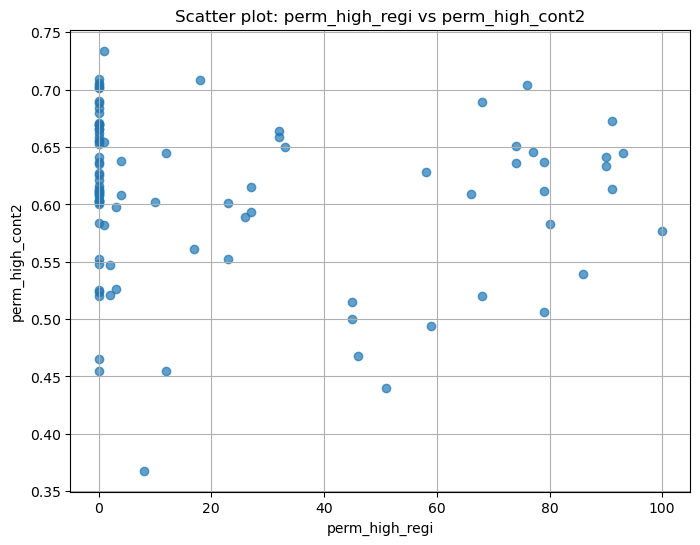

In [83]:
import matplotlib.pyplot as plt

# Choose two columns to plot
x = estreams_attributes_clipped['perm_medium_regi']
y = estreams_attributes_clipped['baseflow_index']

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.7)
plt.xlabel('perm_high_regi')
plt.ylabel('perm_high_cont2')
plt.title('Scatter plot: perm_high_regi vs perm_high_cont2')
plt.grid(True)
plt.show()


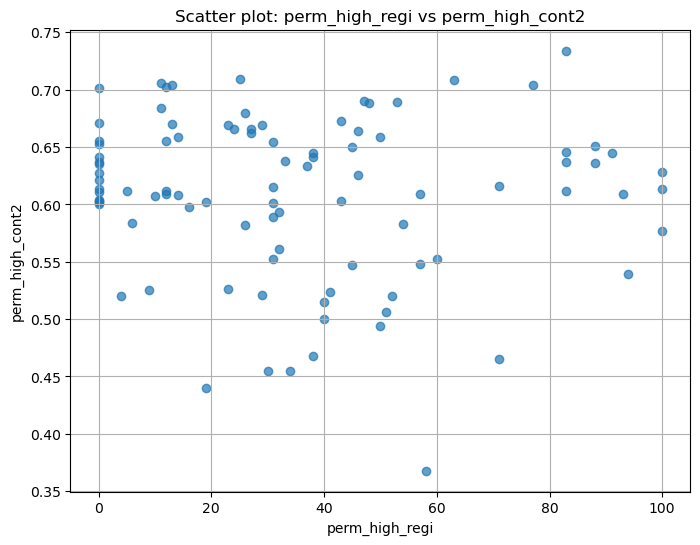

In [82]:
import matplotlib.pyplot as plt

# Choose two columns to plot
x = estreams_attributes_clipped['perm_medium_cont2']
y = estreams_attributes_clipped['baseflow_index']

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.7)
plt.xlabel('perm_high_regi')
plt.ylabel('perm_high_cont2')
plt.title('Scatter plot: perm_high_regi vs perm_high_cont2')
plt.grid(True)
plt.show()


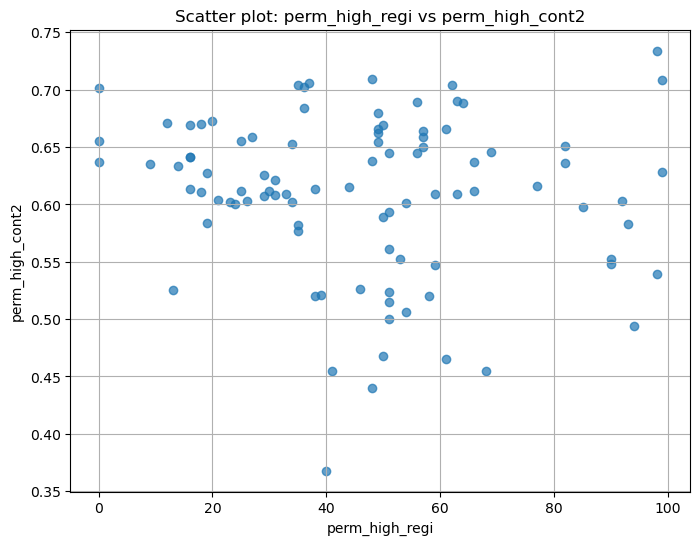

In [81]:
import matplotlib.pyplot as plt

# Choose two columns to plot
x = estreams_attributes_clipped['perm_medium_glob2']
y = estreams_attributes_clipped['baseflow_index']

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.7)
plt.xlabel('perm_high_regi')
plt.ylabel('perm_high_cont2')
plt.title('Scatter plot: perm_high_regi vs perm_high_cont2')
plt.grid(True)
plt.show()


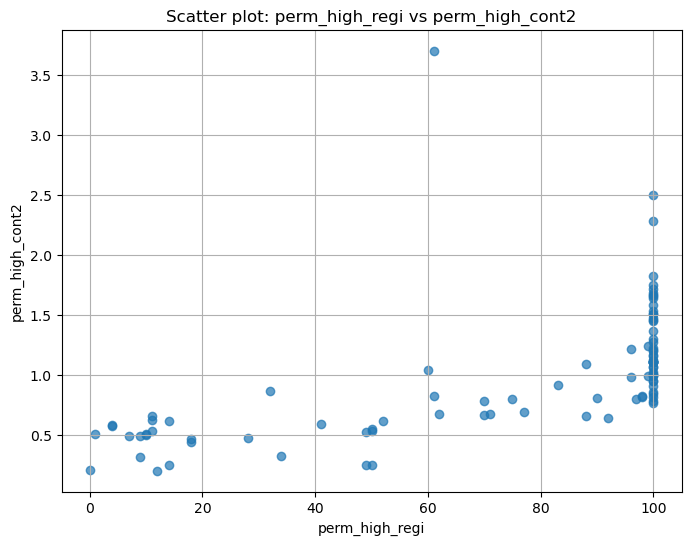

In [68]:
import matplotlib.pyplot as plt

# Choose two columns to plot
x = estreams_attributes_clipped['perm_low_regi']
y = estreams_attributes_clipped['q_mean']

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.7)
plt.xlabel('perm_high_regi')
plt.ylabel('perm_high_cont2')
plt.title('Scatter plot: perm_high_regi vs perm_high_cont2')
plt.grid(True)
plt.show()


In [70]:
len(catchments_ids)

95

In [71]:
# Initialize the dictionary
inputs = {}
observations = {}
areas = {}
perm_areas = {}
quality_masks = {}
rootdepth_mean = {}
waterdeficit_mean = {}
perm_areasglobal = {}
perm_areascontinental = {}
prec_mean = {}

# Function to compute S_dem per water year
def compute_S_dem(group):
    group = group.copy()
    group.iloc[0, group.columns.get_loc('S_dem(t-1)')] = 0
    group.iloc[0, group.columns.get_loc('S_dem(t)')] = max(
        0, group.iloc[0]['S_dem(t-1)'] + (group.iloc[0]['pet_mean'] - group.iloc[0]['p_mean'])
    )

    for i in range(1, len(group)):
        group.iloc[i, group.columns.get_loc('S_dem(t-1)')] = group.iloc[i - 1]['S_dem(t)']
        group.iloc[i, group.columns.get_loc('S_dem(t)')] = max(
            0, group.iloc[i]['S_dem(t-1)'] + (group.iloc[i]['pet_mean'] - group.iloc[i]['p_mean'])
        )

    return group


for basin_id in tqdm.tqdm(catchments_ids):
    
    data = pd.read_csv(path_estreams+"\data\estreams_timeseries_"+basin_id+".csv", index_col=0)

    area = network_estreams.loc[basin_id, "area_estreams"]

    data["Q"] = data.loc[:, "q_mean"]
    data["Q"] = (data.Q * 86400 * 1000) / (area * 1000000)

    # Define the subset to be used:
    #data = data.loc["1988":"2001", :]
    data = data.loc["2001-10-01":"2015-09-30"]


    # Interpolate when needed:
    data['pet_mean'] = data['pet_mean'].interpolate()
    data['t_mean'] = data['t_mean'].interpolate()
    data['p_mean'] = data['p_mean'].interpolate()


    data_wd = data.copy()
    data_wd.index = pd.to_datetime(data_wd.index)

    ## Define water year (Oct 1 to Sept 30)
    data_wd['water_year'] = np.where(data_wd.index.month >= 10, data_wd.index.year + 1, data_wd.index.year)
    data_wd['S_dem(t-1)'] = np.nan
    data_wd['S_dem(t)'] = np.nan

    # Apply computation per water year
    data_wd = data_wd.groupby('water_year', group_keys=False).apply(compute_S_dem)
    
    ## Compute the 75% quantile of 'S_dem(t)' per water year
    S_dem_75_per_year = data_wd.groupby('water_year')['S_dem(t)'].max()
    S_dem_75_per_year = S_dem_75_per_year.quantile(0.75)

    # Save the variables:
    Q_obs = data.loc[:, "Q"].values
    P = data.loc[:, "p_mean"].values
    E = data.loc[:, "pet_mean"].values
    T = data.loc[:, "t_mean"].values
    quality =  (pd.isna(Q_obs)).astype(int)

    inputs[basin_id] = [P, T, E]
    observations[basin_id] = Q_obs
    areas[basin_id] = area
    perm_areas[basin_id] = [round(estreams_attributes.loc[basin_id, "perm_high_regi"] / 100, 2), 
                            round(estreams_attributes.loc[basin_id, "perm_medium_regi"] / 100, 2), 
                            round(estreams_attributes.loc[basin_id, "perm_low_regi"] / 100, 2)]
    
    perm_areasglobal[basin_id] = [round(estreams_attributes.loc[basin_id, "perm_high_glob2"] / 100, 2), 
                            round(estreams_attributes.loc[basin_id, "perm_medium_glob2"] / 100, 2), 
                            round(estreams_attributes.loc[basin_id, "perm_low_glob2"] / 100, 2)]
    
    perm_areascontinental[basin_id] = [round(estreams_attributes.loc[basin_id, "perm_high_cont2"] / 100, 2), 
                            round(estreams_attributes.loc[basin_id, "perm_medium_cont2"] / 100, 2), 
                            round(estreams_attributes.loc[basin_id, "perm_low_cont2"] / 100, 2)]

    quality_masks[basin_id] = quality
    rootdepth_mean[basin_id] = estreams_attributes.loc[basin_id, "root_dep_mean"]
    waterdeficit_mean[basin_id] = np.float64(round(S_dem_75_per_year, 1))
    prec_mean[basin_id] = estreams_attributes.loc[basin_id, "p_mean"]

100%|██████████| 95/95 [03:58<00:00,  2.52s/it]


In [1]:
rootdepth_mean

NameError: name 'rootdepth_mean' is not defined

In [37]:
# Convert dictionary to DataFrame
nan_counts_df = pd.DataFrame.from_dict(nan_counts_dict, orient="index").reset_index()
nan_counts_df.rename(columns={"index": "basin_id"}, inplace=True)
nan_counts_df

,basin_id,p_mean,t_mean,pet_mean,q_mean
0,ES000333,0,0,0,3727
1,ES000453,0,0,0,3622
2,FR004086,0,0,0,131
3,FR004089,0,0,0,901
4,FR004091,0,0,0,0
...,...,...,...,...,...
59,FR001593,0,0,0,529
60,FR001595,0,0,0,2528
61,FR001596,0,0,0,4748
62,FR001602,0,0,0,0


In [72]:
print(nan_counts_df[nan_counts_df.p_mean>0])
print(nan_counts_df[nan_counts_df.t_mean>0])
print(nan_counts_df[nan_counts_df.pet_mean>0])

NameError: name 'nan_counts_df' is not defined

In [73]:
# Save the dictionaries
path_inputs = r'..\data\models\inputvienne\subset_2001_2015'

np.save(path_inputs+'\\inputs.npy', inputs)
np.save(path_inputs+'\\observations.npy', observations)
np.save(path_inputs+'\\areas.npy', areas)
np.save(path_inputs+'\\perm_areas.npy', perm_areas)
np.save(path_inputs+'\\quality_masks.npy', quality_masks)
np.save(path_inputs+'\\rootdepth_mean.npy', rootdepth_mean)
np.save(path_inputs+'\\waterdeficit_mean.npy', waterdeficit_mean)
np.save(path_inputs+'\\perm_areasglobal.npy', perm_areasglobal)
np.save(path_inputs+'\\perm_areascontinental.npy', perm_areascontinental)
np.save(path_inputs+'\\prec_mean.npy', prec_mean)

In [76]:
perm_areascontinental

{'FR003936': [0.0, 0.0, 1.0],
 'FR003937': [0.0, 0.47, 0.53],
 'FR003938': [0.0, 0.0, 1.0],
 'FR003939': [0.0, 0.0, 1.0],
 'FR003940': [0.0, 0.25, 0.75],
 'FR003941': [0.0, 0.41, 0.59],
 'FR003942': [0.0, 0.6, 0.4],
 'FR003943': [0.0, 0.29, 0.71],
 'FR003944': [0.0, 0.71, 0.29],
 'FR003945': [0.04, 0.38, 0.58],
 'FR003946': [0.08, 0.88, 0.04],
 'FR003949': [0.09, 0.83, 0.08],
 'FR003951': [0.63, 0.37, 0.0],
 'FR003952': [0.18, 0.77, 0.05],
 'FR003953': [0.12, 0.51, 0.37],
 'FR003954': [0.13, 0.5, 0.37],
 'FR003955': [0.0, 0.0, 1.0],
 'FR003956': [0.0, 0.0, 1.0],
 'FR003957': [0.0, 0.0, 1.0],
 'FR003959': [0.01, 0.23, 0.76],
 'FR003960': [0.0, 0.46, 0.54],
 'FR003961': [0.42, 0.5, 0.08],
 'FR003963': [0.11, 0.32, 0.57],
 'FR003964': [0.16, 0.31, 0.53],
 'FR003965': [0.0, 0.23, 0.77],
 'FR003967': [0.0, 0.05, 0.95],
 'FR003968': [0.0, 0.1, 0.9],
 'FR003969': [0.0, 0.12, 0.88],
 'FR003970': [0.04, 0.14, 0.82],
 'FR003971': [0.04, 0.19, 0.77],
 'FR003972': [0.09, 0.34, 0.57],
 'FR003974': 

In [75]:
perm_areas

{'FR003936': [0.0, 0.0, 1.0],
 'FR003937': [0.0, 0.0, 1.0],
 'FR003938': [0.0, 0.0, 1.0],
 'FR003939': [0.0, 0.0, 1.0],
 'FR003940': [0.0, 0.0, 1.0],
 'FR003941': [0.0, 0.0, 1.0],
 'FR003942': [0.0, 0.0, 1.0],
 'FR003943': [0.0, 0.0, 1.0],
 'FR003944': [0.0, 0.0, 1.0],
 'FR003945': [0.0, 0.12, 0.88],
 'FR003946': [0.22, 0.74, 0.04],
 'FR003949': [0.12, 0.77, 0.11],
 'FR003951': [0.0, 0.9, 0.1],
 'FR003952': [0.1, 0.76, 0.14],
 'FR003953': [0.07, 0.32, 0.61],
 'FR003954': [0.08, 0.32, 0.6],
 'FR003955': [0.0, 0.0, 1.0],
 'FR003956': [0.0, 0.0, 1.0],
 'FR003957': [0.0, 0.0, 1.0],
 'FR003959': [0.0, 0.03, 0.97],
 'FR003960': [0.0, 0.0, 1.0],
 'FR003961': [0.0, 0.59, 0.41],
 'FR003963': [0.0, 0.17, 0.83],
 'FR003964': [0.0, 0.23, 0.77],
 'FR003965': [0.0, 0.0, 1.0],
 'FR003967': [0.0, 0.0, 1.0],
 'FR003968': [0.0, 0.0, 1.0],
 'FR003969': [0.0, 0.0, 1.0],
 'FR003970': [0.0, 0.04, 0.96],
 'FR003971': [0.0, 0.1, 0.9],
 'FR003972': [0.0, 0.12, 0.88],
 'FR003974': [0.0, 0.0, 1.0],
 'FR003976': 

In [23]:
# Initialize the dictionary
inputs = {}
observations = {}
areas = {}
perm_areas = {}
quality_masks = {}
rootdepth_mean = {}
waterdeficit_mean = {}
perm_areasglobal = {}
perm_areascontinental = {}
prec_mean = {}

# Function to compute S_dem per water year
def compute_S_dem(group):
    group = group.copy()
    group.iloc[0, group.columns.get_loc('S_dem(t-1)')] = 0
    group.iloc[0, group.columns.get_loc('S_dem(t)')] = max(
        0, group.iloc[0]['S_dem(t-1)'] + (group.iloc[0]['pet_mean'] - group.iloc[0]['p_mean'])
    )

    for i in range(1, len(group)):
        group.iloc[i, group.columns.get_loc('S_dem(t-1)')] = group.iloc[i - 1]['S_dem(t)']
        group.iloc[i, group.columns.get_loc('S_dem(t)')] = max(
            0, group.iloc[i]['S_dem(t-1)'] + (group.iloc[i]['pet_mean'] - group.iloc[i]['p_mean'])
        )

    return group

nan_counts_dict = {}

for basin_id in tqdm.tqdm(catchments_ids):
    
    data = pd.read_csv(path_estreams+"\data\estreams_timeseries_"+basin_id+".csv", index_col=0)

    area = network_estreams.loc[basin_id, "area_estreams"]

    data["Q"] = data.loc[:, "q_mean"]
    data["Q"] = (data.Q * 86400 * 1000) / (area * 1000000)

    # Define the subset to be used:
    data = data.loc["1988-10-01":"2001-09-30", :]
    #data = data.loc["2001-10-01":"2015-09-30"]

    # Count NaN values in P and T
    nan_counts_dict[basin_id] = {
        "p_mean": data["p_mean"].isna().sum(),
        "t_mean": data["t_mean"].isna().sum(),
        "pet_mean": data["t_mean"].isna().isna().sum(),
        "q_mean": data["q_mean"].isna().sum()
        }
    

    # Interpolate when needed:
    data['pet_mean'] = data['pet_mean'].interpolate()
    data['t_mean'] = data['t_mean'].interpolate()
    data['p_mean'] = data['p_mean'].interpolate()


    data_wd = data.copy()
    data_wd.index = pd.to_datetime(data_wd.index)

    # Define water year (Oct 1 to Sept 30)

    data_wd['water_year'] = np.where(data_wd.index.month >= 10, data_wd.index.year + 1, data_wd.index.year)
    data_wd['S_dem(t-1)'] = np.nan
    data_wd['S_dem(t)'] = np.nan

    # Apply computation per water year
    data_wd = data_wd.groupby('water_year', group_keys=False).apply(compute_S_dem)
    
    # Compute the 75% quantile of 'S_dem(t)' per water year
    S_dem_75_per_year = data_wd.groupby('water_year')['S_dem(t)'].max()
    S_dem_75_per_year = S_dem_75_per_year.quantile(0.75)

    # Save the variables:
    Q_obs = data.loc[:, "Q"].values
    P = data.loc[:, "p_mean"].values
    E = data.loc[:, "pet_mean"].values
    T = data.loc[:, "t_mean"].values
    quality =  (pd.isna(Q_obs)).astype(int)

    inputs[basin_id] = [P, T, E]
    observations[basin_id] = Q_obs
    areas[basin_id] = area
    perm_areas[basin_id] = [round(estreams_attributes.loc[basin_id, "perm_high_regi"] / 100, 2), 
                            round(estreams_attributes.loc[basin_id, "perm_medium_regi"] / 100, 2), 
                            round(estreams_attributes.loc[basin_id, "perm_low_regi"] / 100, 2)]
    
    perm_areasglobal[basin_id] = [round(estreams_attributes.loc[basin_id, "perm_high_glob2"] / 100, 2), 
                            round(estreams_attributes.loc[basin_id, "perm_medium_glob2"] / 100, 2), 
                            round(estreams_attributes.loc[basin_id, "perm_low_glob2"] / 100, 2)]
    
    perm_areascontinental[basin_id] = [round(estreams_attributes.loc[basin_id, "perm_high_cont2"] / 100, 2), 
                            round(estreams_attributes.loc[basin_id, "perm_medium_cont2"] / 100, 2), 
                            round(estreams_attributes.loc[basin_id, "perm_low_cont2"] / 100, 2)]

    quality_masks[basin_id] = quality
    rootdepth_mean[basin_id] = estreams_attributes.loc[basin_id, "root_dep_mean"]
    waterdeficit_mean[basin_id] = np.float64(round(S_dem_75_per_year, 1))
    prec_mean[basin_id] = estreams_attributes.loc[basin_id, "p_mean"]

100%|██████████| 95/95 [03:19<00:00,  2.10s/it]


In [18]:
# Convert dictionary to DataFrame
nan_counts_df = pd.DataFrame.from_dict(nan_counts_dict, orient="index").reset_index()
nan_counts_df.rename(columns={"index": "basin_id"}, inplace=True)
nan_counts_df

,basin_id,p_mean,t_mean,pet_mean,q_mean
0,FR003936,0,0,0,2225
1,FR003937,0,0,0,0
2,FR003938,0,0,0,0
3,FR003939,0,0,0,2538
4,FR003940,0,0,0,4748
...,...,...,...,...,...
90,FR001250,0,0,0,4748
91,FR001253,0,0,0,0
92,FR001256,0,0,0,4748
93,FR001257,0,0,0,3296


In [20]:
print(nan_counts_df[nan_counts_df.p_mean>0])
print(nan_counts_df[nan_counts_df.t_mean>0])
print(nan_counts_df[nan_counts_df.pet_mean>0])

Empty DataFrame
Columns: [basin_id, p_mean, t_mean, pet_mean, q_mean]
Index: []
Empty DataFrame
Columns: [basin_id, p_mean, t_mean, pet_mean, q_mean]
Index: []
Empty DataFrame
Columns: [basin_id, p_mean, t_mean, pet_mean, q_mean]
Index: []


In [24]:
# Save the dictionaries
path_inputs = r'..\data\models\inputvienne\subset_1988_2001'

np.save(path_inputs+'\\inputs.npy', inputs)
np.save(path_inputs+'\\observations.npy', observations)
np.save(path_inputs+'\\areas.npy', areas)
np.save(path_inputs+'\\perm_areas.npy', perm_areas)
np.save(path_inputs+'\\quality_masks.npy', quality_masks)
np.save(path_inputs+'\\rootdepth_mean.npy', rootdepth_mean)
np.save(path_inputs+'\\waterdeficit_mean.npy', waterdeficit_mean)
np.save(path_inputs+'\\perm_areasglobal.npy', perm_areasglobal)
np.save(path_inputs+'\\perm_areascontinental.npy', perm_areascontinental)
np.save(path_inputs+'\\prec_mean.npy', prec_mean)

# End